# Initialization

In [1]:
USE_MP = False
import silq

silq.initialize("EWJN")

qc.show_subprocess_widget()
%matplotlib nbagg

Initializing imports


<IPython.core.display.Javascript object>

Initializing functions
Initializing instruments
Connected to: Agilent Technologies E8267D (serial:SG53400039, firmware:C.06.22) in 0.04s
Initializing layout
Initializing data
Initializing analysis
Initializing parameters
Initializing plotting
Initialization complete


In [2]:
calibration_operations = [
    {'mode': 'measure'},
    {'mode': '1D_scan', 'span': 0.007, 'set_points': 12, 'set_parameter': 'DF_DS'},
    {'mode': '1D_scan', 'span': 0.015, 'set_points': 25, 'set_parameter': 'DF_DS'}]
conditions =  [('contrast', 0.6, '>')]
autocal_parameter = measurement_parameters.AutoCalibration_Parameter(
    name='autocal', set_parameters=[DF_DS], measure_parameter=adiabatic_ESR_parameter, 
    calibration_operations=calibration_operations, key='contrast', conditions=conditions)

## Common settings

In [22]:
DF_DS(0.417)
TGAC(0.4876)

In [3]:
# Setup pulses
EPR_parameter.pulse_sequence['read'].duration=120
adiabatic_ESR_parameter.pulse_sequence['read'].duration=120
adiabatic_NMR_parameter.pulse_sequence['read'].duration=120
select_ESR_parameter.pulse_sequence['read'].duration = 120

dark_counts_parameter.pulse_sequence['steered_initialization'].t_no_blip= 200
dark_counts_parameter.pulse_sequence['steered_initialization'].t_max_wait= 1000

## Threshold voltage

In [21]:
EPR_parameter.single_settings(samples=50)
EPR_parameter.setup()
voltage_difference = EPR_parameter()[-1]

assert voltage_difference, "Couldn't find accurate threshold"
readout_threshold_voltage = voltage_difference / 2

print('Threshold voltage found at {:.2f} V'.format(readout_threshold_voltage))
properties_config['readout_threshold_voltage'] = readout_threshold_voltage

Threshold voltage found at 0.33 V


## ESR frequency

In [26]:
adiabatic_ESR_parameter.temporary_settings(samples=30)
select_ESR_parameter.single_settings(silent=False)
select_ESR_parameter();
adiabatic_ESR_parameter.clear_settings()

contrastdown: 0.267
contrastup: 0.000
frequency_ESR: 27951000000.000


# DC Measurements

## DC - Turnon
Here several gates are combined to the parameter turnon_param.

In [ ]:
turnon_vals = turnon_parameter[list(np.linspace(1, 1.6, 100))]

In [ ]:
DC_parameter.setup()
data = qc.Loop(turnon_vals
# data = qc.Loop(dummy_parameter[0:1000:1], delay=1
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='turnon',
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

## DC - Pinchoff
This code pinches off one gate, while keeping the other gates fixed

In [ ]:
turnon_voltage = 1.6
pinchoff_vals = list(np.linspace(turnon_voltage, 0, 100))
gate = TG

turnon_parameter(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gate[pinchoff_vals]
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

In [ ]:
turnon_voltage = 1.3
pinchoff_vals = list(np.linspace(turnon_voltage, 0.7, 40))
gatex=LB
gatey=RB

turnon_parameter(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gatey[pinchoff_vals]
               ).loop(gatex[pinchoff_vals]
                      ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='2D_Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)


## DC - 1D scan
This script performs a 1D DC scan

In [ ]:
gate = DF_DS[list(np.linspace(0.28,0.6, 50))]

DC_parameter.setup()
data = qc.Loop(gate
              ).each(DC_parameter
                    ).then(qc.Task(layout.stop)
                          ).run(name='DC_{}_scan'.format(gate.name),
                                progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

## DC - 2D scan

This measurement performs a 2D DC scan

Waiting for the previous background Loop to finish...
...done. Starting 2016-12-16/#004_DC_TGAC_vs_DF_DS_scan_12-14-52
DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-16/#004_DC_TGAC_vs_DF_DS_scan_12-14-52'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | TGAC_set   | TGAC         | (100,)
   Setpoint | DF_DS_set  | DF_DS        | (100, 100)
   Measured | DC_voltage | DC_voltage   | (100, 100)
started at 2016-12-16 12:14:55


<IPython.core.display.Javascript object>


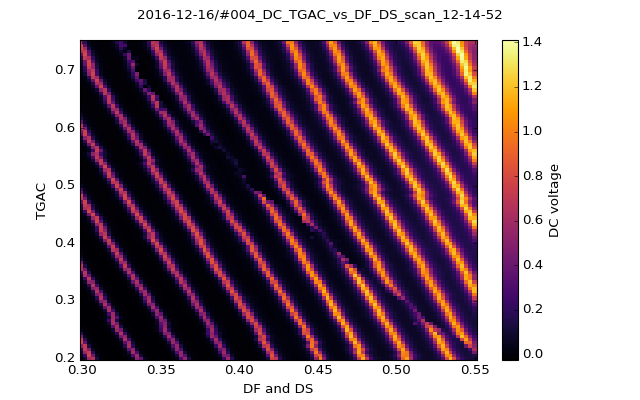

In [21]:
gate_x = DF_DS[list(np.linspace(0.3, 0.55, 100))]
gate_y = TGAC[list(np.linspace(0.2,0.75, 100))]

DC_parameter.setup()
data = qc.Loop(gate_y
              ).loop(gate_x
                    ).each(DC_parameter
                          ).then(qc.Task(layout.stop)
                                ).run(name='DC_{}_vs_{}_scan'.format(gate_y.name, gate_x.name),
                                      progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

# EPR measurements (no steering/ESR)

This is a calibration routine to find a point with high contrast (difference in signal between up state and down state). 
This measurement consists of three stages: empty, load, and read.
In the empty stage, the donor atom is ionized. 
It is then loaded with an electron in a random state.
Finally the state is read out for a long duration.
The contrast is found by looking if blips occured at the beginning of the read trace and at the end of the read trace.
The contrast is the difference in percentage of blips occuring at the beginning versus at the end.
The end part of the read trace is related to the number of dark counts, since we assume that an up-state electron will have had enough time to have tunneled off and on again.

## EPR - 2D scan

In [23]:
DF_DS_vals = list(np.linspace(0.41, 0.422, 14))
TGAC_vals = list(np.linspace(0.46,0.5, 14))

In [24]:
EPR_parameter.setup(samples=150, t_read=20)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(EPR_parameter
                          ).run(name='EPR_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-16/#005_EPR_calibration_15-04-34'
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | TGAC_set           | TGAC               | (14,)
   Setpoint | DF_DS_set          | DF_DS              | (14, 14)
   Measured | contrast           | contrast           | (14, 14)
   Measured | dark_counts        | dark_counts        | (14, 14)
   Measured | voltage_difference | voltage_difference | (14, 14)
   Measured | fidelity_empty     | fidelity_empty     | (14, 14)
   Measured | fidelity_load      | fidelity_load      | (14, 14)
started at 2016-12-16 15:04:38


<IPython.core.display.Javascript object>


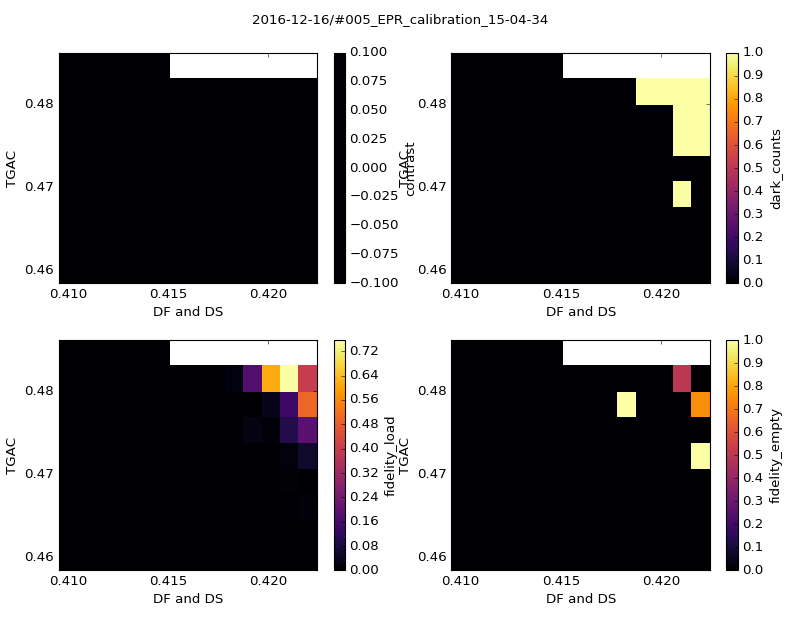

In [25]:
plot = CalibrationPlot(data)
# ax = plot.plot.subplots[0]
# ax.qcodes_colorbar.set_clim(0,0.35)

## EPR - Single point

In [9]:
EPR_parameter.setup(samples=150, silent=False)
EPR_parameter();

contrast: 0.240
dark_counts: 0.253
voltage_difference: 0.395
fidelity_empty: 0.603
fidelity_load: 1.000


# Adiabatic sweep measurements

## ESR Adiabatic - Center frequency scan

This code sweeps over the adiabatic sweep center frequency to find the ESR frequency.

To find the ESR frequency, use 28GHz * B0 as starting point, and search around that frequency.
Use a big initial frequency_deviation (around 60 MHz) and long duration (0.5 ms)
Once you see a spike in contrast, center around there and decrease both deviation and duration.

In [22]:
f_center = frequency_center_ESR['down']
f_span = 5e6
f_step = 0.25e6
adiabatic_sweep_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(adiabatic_sweep_vals)))

Sweep vals: 20


DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-13/#018_adiabatic_ESR_f_center_16-38-19'
   <Type>   | <array_id>          | <array.name>    | <array.shape>
   Setpoint | adiabatic_sweep_set | adiabatic_sweep | (20,)
   Measured | fidelity_load       | fidelity_load   | (20,)
   Measured | fidelity_read       | fidelity_read   | (20,)
   Measured | up_proportion       | up_proportion   | (20,)
   Measured | dark_counts         | dark_counts     | (20,)
   Measured | contrast            | contrast        | (20,)
started at 2016-12-13 16:38:23


<IPython.core.display.Javascript object>


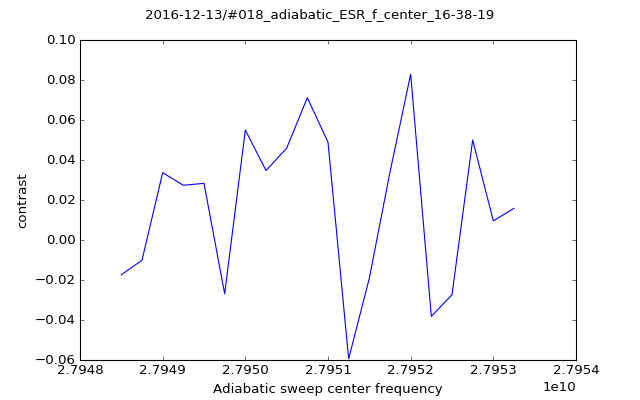

In [23]:
adiabatic_ESR_parameter.setup(samples=80)
data = qc.Loop(adiabatic_ESR_parameter[adiabatic_sweep_vals]
                     ).each(adiabatic_ESR_parameter
                           ).run(name='adiabatic_ESR_f_center',
                                progress_interval=True)
plot = qc.MatPlot(data.contrast, use_offset=False)

## NMR adiabatic frequency scan

In [ ]:
#NMR sweep frequencies
f_center = 66.82e6
f_span = 3e6
f_step = 20e3
NMR_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(NMR_vals)))

In [ ]:
data = qc.Loop(adiabatic_NMR_parameter[NMR_vals]
              ).each(qc.Task(adiabatic_NMR_parameter.setup),
                     adiabatic_NMR_parameter,
                     qc.Task(partial(adiabatic_ESR_parameter, frequency_center_ESR['up'])),
                     adiabatic_ESR_parameter,
                     qc.Task(partial(adiabatic_ESR_parameter, frequency_center_ESR['down'])),
                     adiabatic_ESR_parameter,
                    ).run(name='NMR_adiabatic_sweep', progress_interval=True)

In [ ]:
plot = qc.MatPlot(data.contrast_3_4)
plot.add(data.contrast_5_4)

## Adiabatic - frequency deviation versus ESR duration

This is a 2D scan of frequency deviation versus duration.
From this measurement, the minimum acceptable values for frequency deviation and ESR duration can be extracted.

In [ ]:
pulse = adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep']
adiabatic_deviation_parameter = general_parameters.AttributeParameter(object=pulse, attribute='frequency_deviation')
adiabatic_duration_parameter = general_parameters.AttributeParameter(object=pulse, attribute='duration')

adiabatic_deviation_vals = list(np.logspace(5.5, 7.8, 8))
adiabatic_duration_vals = list(np.logspace(-2.7, -0.3, 8))

In [ ]:
adiabatic_sweep_parameter.pulse_sequence['read'].duration = 100
adiabatic_sweep_parameter.setup(samples=400)
adiabatic_sweep_parameter(frequency_center)
data = qc.Loop(adiabatic_deviation_parameter[adiabatic_deviation_vals]
              ).loop(adiabatic_duration_parameter[adiabatic_duration_vals]
                    ).each(adiabatic_sweep_parameter
                          ).run(name='adiabatic_deviation_vs_duration',
                                progress_interval=True)

In [ ]:
plot = qc.MatPlot(subplots=(1,2), figsize=(12,5), interval=10)
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
# for ax in plot.subplots:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Adiabatic - 2D scan

In [36]:
DF_DS_vals = list(np.linspace(0.462, 0.475, 20))
TGAC_vals = list(np.linspace(0.37,0.41, 20))

In [37]:
adiabatic_ESR_parameter.setup(samples=200, save_traces=False)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(adiabatic_ESR_parameter
                          ).run(name='adiabatic_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-17/#003_adiabatic_calibration_11-06-52'
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | TGAC_set           | TGAC               | (20,)
   Setpoint | DF_DS_set          | DF_DS              | (20, 20)
   Measured | contrast           | contrast           | (20, 20)
   Measured | dark_counts        | dark_counts        | (20, 20)
   Measured | voltage_difference | voltage_difference | (20, 20)
started at 2016-12-17 11:06:56


<IPython.core.display.Javascript object>


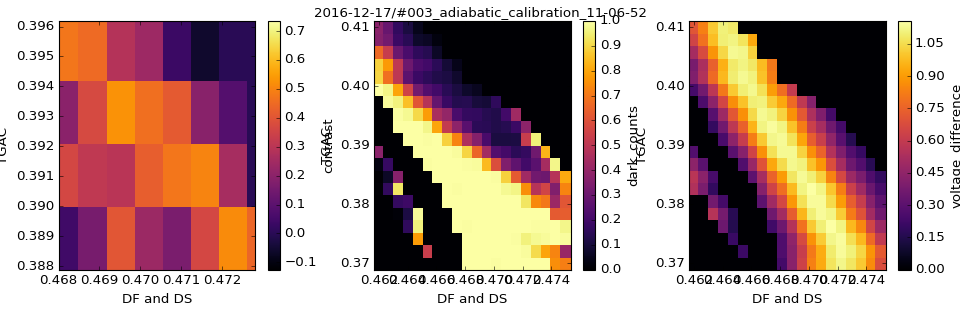

In [38]:
plot = qc.MatPlot(subplots=(1, 3), figsize=(12, 4))
plot.add(data.contrast, subplot=1)
plot.add(data.dark_counts, subplot=2)
plot.add(data.voltage_difference, subplot=3)
plt.tight_layout()

In [39]:
DF_DS(0.470)
TGAC(0.393)

## Adiabatic - Single point

In [40]:
adiabatic_ESR_parameter.setup(samples=150, silent=False)
%time adiabatic_ESR_parameter();

contrast: 0.547
dark_counts: 0.173
voltage_difference: 0.673
Wall time: 20.7 s


[0.54666666666666663, 0.17333333333333334, 0.67313270979015893]

## Adiabatic - Compare adiabatic settings

In [12]:
pulse = adiabatic_ESR_parameter.pulse_sequence['adiabatic_sweep']
adiabatic_deviation_parameter = general_parameters.AttributeParameter(object=pulse, attribute='frequency_deviation')
adiabatic_duration_parameter = general_parameters.AttributeParameter(object=pulse, attribute='duration')


adiabatic_ESR_parameter.setup(samples=250, readout_threshold_voltage=readout_threshold_voltage,
                                save_traces=False)
data = qc.Loop(dummy_parameter[0:100:1]
              ).each(qc.Task(adiabatic_deviation_parameter, 5e6),
                     qc.Task(adiabatic_duration_parameter, .15),
                     qc.Task(adiabatic_ESR_parameter.setup),
                     adiabatic_ESR_parameter,
                     qc.Task(adiabatic_deviation_parameter, 15e6),
                     qc.Task(adiabatic_duration_parameter, .35),
                     qc.Task(adiabatic_ESR_parameter.setup),
                     adiabatic_ESR_parameter,
                    ).run(name='adiabatic_calibration',
                          progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-12/#027_adiabatic_calibration_15-54-48'
   <Type>   | <array_id>        | <array.name>  | <array.shape>
   Setpoint | dummy_set         | dummy         | (100,)
   Measured | fidelity_load_3_0 | fidelity_load | (100,)
   Measured | fidelity_read_3_1 | fidelity_read | (100,)
   Measured | up_proportion_3_2 | up_proportion | (100,)
   Measured | dark_counts_3_3   | dark_counts   | (100,)
   Measured | contrast_3_4      | contrast      | (100,)
   Measured | fidelity_load_7_0 | fidelity_load | (100,)
   Measured | fidelity_read_7_1 | fidelity_read | (100,)
   Measured | up_proportion_7_2 | up_proportion | (100,)
   Measured | dark_counts_7_3   | dark_counts   | (100,)
   Measured | contrast_7_4      | contrast      | (100,)
started at 2016-12-12 15:54:51


<IPython.core.display.Javascript object>


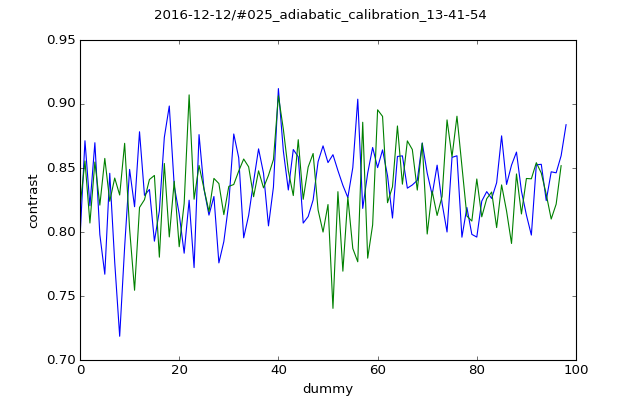

In [21]:
plot = qc.MatPlot(data.contrast_3_4);
plot.add(data.contrast_7_4)

## Flip nucleus

In [105]:
# Try to flip the nucleus
adiabatic_NMR_parameter(frequency_center_NMR)
adiabatic_NMR_parameter.samples = 1
adiabatic_NMR_parameter();

Found 3 peaks instead of two, increasing threshold
Found 3 peaks instead of two, increasing threshold


C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


## Find ESR frequency

In [18]:
select_ESR_parameter.setup(samples=50, print_results=True, readout_threshold_voltage=readout_threshold_voltage)
data = qc.Loop(dummy_parameter[0:100:1]).each(qc.Task(adiabatic_NMR_parameter.setup),
                                             adiabatic_NMR_parameter,
                                             qc.Task(select_ESR_parameter.setup),
                                             select_ESR_parameter,
                                             qc.Task(adiabatic_ESR_parameter, partial(getattr, select_ESR_parameter, 'frequency_ESR')),
                                             qc.Task(adiabatic_deviation_parameter, 5e6),
                                             qc.Task(adiabatic_duration_parameter, .15),
                                             qc.Task(adiabatic_ESR_parameter.setup),
                                             adiabatic_ESR_parameter,
                                             qc.Task(adiabatic_deviation_parameter, 15e6),
                                             qc.Task(adiabatic_duration_parameter, .35),
                                             qc.Task(adiabatic_ESR_parameter.setup),
                                             adiabatic_ESR_parameter,
                                            ).run(name='test_find_ESR',
                                                 progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-12/#029_test_find_ESR_16-05-49'
   <Type>   | <array_id>         | <array.name>     | <array.shape>
   Setpoint | dummy_set          | dummy            | (100,)
   Measured | fidelity_load_1_0  | fidelity_load    | (100,)
   Measured | fidelity_read_1_1  | fidelity_read    | (100,)
   Measured | up_proportion_1_2  | up_proportion    | (100,)
   Measured | dark_counts_1_3    | dark_counts      | (100,)
   Measured | contrast_1_4       | contrast         | (100,)
   Measured | dark_counts_up     | dark_counts_up   | (100,)
   Measured | contrast_up        | contrast_up      | (100,)
   Measured | dark_counts_down   | dark_counts_down | (100,)
   Measured | contrast_down      | contrast_down    | (100,)
   Measured | ESR_frequency      | ESR_frequency    | (100,)
   Measured | fidelity_load_8_0  | fidelity_load    | (100,)
   Measured | fidelity_read_8_1  | fidelity_read    | (100,)
   Measured | up_proportion_8_2  | 

<IPython.core.display.Javascript object>


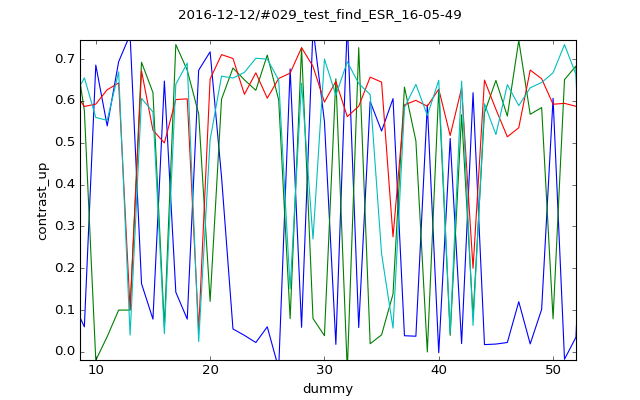

In [19]:
plot = qc.MatPlot(data.contrast_up, label='nucleus up')
plot.add(data.contrast_down, label='nucleus down')
plot.add(data.contrast_8_4, label='ESR narrow')
plot.add(data.contrast_12_4, label='ESR wide')

# Dark counts

## Dark - Parameter settings

In [40]:
dark_counts_parameter.pulse_sequence['read'].duration = 20

dark_counts_parameter.setup(readout_threshold_voltage, samples=20, print_results=True)
dark_counts_parameter.pulse_sequence

PulseSequence with 6 pulses, duration: 22
	SteeredInitialization(steered_initialization, t_no_blip=200 ms, t_max_wait=1000, t_buffer=20)
	DCPulse(read, A=0, t_start=0, t_stop=20)
	DCPulse(final, A=0, t_start=20, t_stop=22)
	
	Disabled pulses:
	DCPulse(empty, A=-1.5, t_start=0, t_stop=5)
	DCPulse(plunge, A=1.8, t_start=0, t_stop=5)
	FrequencyRampPulse(adiabatic_sweep, f_start=19995.00 MHz, f_stop=20005.00, power=10, t_start=14, t_stop=14.2)

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18,5))

# Initialization buffers showing how long it takes before it starts plunging
plot_traces(steered_controller.initialization_traces(), ax=axes[0])
plt.title('Initialization trace\nOutput signal')

# Post initialization buffer showing if blips occurred or not
plot_traces(steered_controller.post_initialization_traces()['A'], ax=axes[1])
plt.title('Post initialization buffer\nOutput signal')

# Post initialization buffer of arbstudio showing when it starts plunging
plot_traces(steered_controller.post_initialization_traces()['C'], ax=axes[2])
plt.title('Post initialization buffer\nArbStudio signal')

# Post initialization buffer of arbstudio showing when it starts plunging
plot_traces(adiabatic_sweep_parameter.traces['output'], ax=axes[3])
plt.title('Readout trace\nOutput signal')

plt.tight_layout()

## Dark - Single point

In [ ]:
EPR_parameter.setup(samples=150, print_results=True)
EPR_parameter();

# Read level sweep (to be fixed)

In [ ]:
variable_read_parameter.setup(samples=100)
data = qc.Loop(variable_read_parameter[-1.5:2.5:0.04]
                     ).each(variable_read_parameter
                           ).run(name='variable_read',
                                progress_interval=True)

In [ ]:
plotQ = qc.QtPlot()
plotQ.add(data.Channel_A_signal)

plotQ = qc.QtPlot()
plotQ.add(data.Channel_C_signal)

# T1 measurement

## T1 - Parameter settings

## T1 - Single point

In [ ]:
T1_parameter(10000)
T1_parameter.print_results = True
%time up_proportion,number_traces_loaded = T1_parameter()

## T1 - single scan

In [ ]:
# Calculate T1 durations
T1_wait_times = list(np.logspace(1, 3, num=10, base=10))

# Shuffle times
#np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

In [ ]:
# Single T1 sweep

data = qc.Loop(T1_parameter[T1_wait_times]
                     ).each(T1_parameter
                           ).run(name='T1_single_sweep')

plotQ = qc.MatPlot()
plotQ.add(data.up_proportion)

## T1 - Multiple scans

In [4]:
# Calculate T1 durations (shuffled)
T1_wait_times = list(np.logspace(1, 4.1, num=12, base=10))
np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [12589.254117941662, 36.613088353640322, 19.134546859970403, 134.05182387914726, 6579.3322465756755, 256.50209056800458, 3438.4573069455232, 10.0, 939.13337048598044, 490.80512716538561, 70.057485479096783, 1796.9891485325938]


In [5]:
T1_parameter.samples = 50
dark_counts_parameter.samples = 100
adiabatic_ESR_parameter.samples = 100
data = qc.Loop(dummy_parameter[0:80:1]
              ).each(qc.Task(select_ESR_parameter.setup),
                     select_ESR_parameter,
                     qc.Task(dark_counts_parameter.setup),
                     dark_counts_parameter,
                     qc.Task(T1_parameter.setup),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter),
                     autocal_parameter,
                    ).run(name='T1_data', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-18/#001_T1_data_11-46-20'
   <Type>   | <array_id>          | <array.name>     | <array.shape>
   Setpoint | dummy_set           | dummy            | (80,)
   Measured | contrast_up         | contrast_up      | (80,)
   Measured | dark_counts_up      | dark_counts_up   | (80,)
   Measured | contrast_down       | contrast_down    | (80,)
   Measured | dark_counts_down    | dark_counts_down | (80,)
   Measured | frequency_ESR       | frequency_ESR    | (80,)
   Measured | up_proportion_3_0   | up_proportion    | (80,)
   Measured | num_traces_3_1      | num_traces       | (80,)
   Setpoint | T1_wait_time_set    | T1_wait_time     | (80, 12)
   Measured | up_proportion_5_0_0 | up_proportion    | (80, 12)
   Measured | num_traces_5_0_1    | num_traces       | (80, 12)
   Measured | success             | success          | (80,)
   Measured | optimal_set_val     | optimal_set_val  | (80,)
   Measured | contrast         

<IPython.core.display.Javascript object>


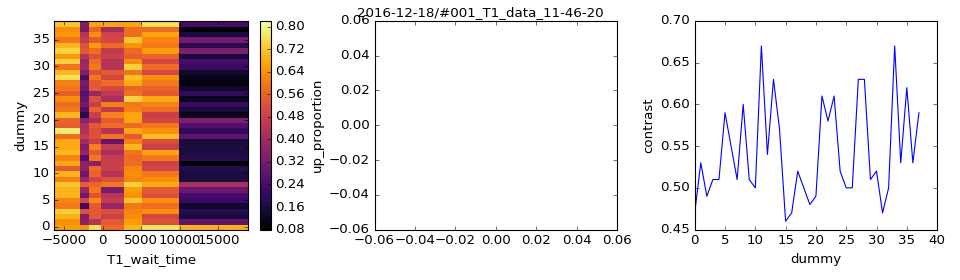

In [16]:
plot = qc.MatPlot(subplots=(1,3), figsize=(12,3.5))
plot.add(data.up_proportion_5_0_0, subplot=1)
# plot.subplots[0].set_xscale('log')
# plot.add(data.T1_wait_time_set[0], np.nanmean(data.up_proportion_5_0_0, axis=0), subplot=2)
# plot.subplots[1].set_xscale('log')
# plot.subplots[1].set_xlim(10, 13000)
plot.add(data.contrast, subplot=3)
plt.tight_layout()

## T1 - Plunge voltage scan
This scan measures the contrast for a fixed wait time as the plunge voltage is varied

In [3]:
plunge_voltage_parameter = general_parameters.AttributeParameter(
    object=T1_parameter.pulse_sequence['plunge'],
    attribute='voltage')

In [6]:
select_ESR_parameter.setup(samples=30, silent=True)
T1_parameter.setup(samples=40, silent=True)
adiabatic_ESR_parameter.setup(samples=150, silent=True)
dark_counts_parameter.setup(samples=250, silent=True)

T1_parameter(1200)
data = qc.Loop(dummy_parameter[0:70:1]
               ).each(qc.Loop(plunge_voltage_parameter[1:2.5:0.1]
                              ).each(qc.Task(select_ESR_parameter.setup),
                                     select_ESR_parameter,
                                     qc.Task(T1_parameter.setup),
                                     T1_parameter),
                      autocal_parameter,
                      qc.Task(dark_counts_parameter.setup),
                      dark_counts_parameter
                     ).run(name='T1_plunge_voltage', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-15/#023_T1_plunge_voltage_17-22-59'
   <Type>   | <array_id>          | <array.name>     | <array.shape>
   Setpoint | dummy_set           | dummy            | (70,)
   Setpoint | voltage_set         | voltage          | (70, 15)
   Measured | contrast_up         | contrast_up      | (70, 15)
   Measured | dark_counts_up      | dark_counts_up   | (70, 15)
   Measured | contrast_down       | contrast_down    | (70, 15)
   Measured | dark_counts_down    | dark_counts_down | (70, 15)
   Measured | frequency_ESR       | frequency_ESR    | (70, 15)
   Measured | up_proportion_0_3_0 | up_proportion    | (70, 15)
   Measured | num_traces_0_3_1    | num_traces       | (70, 15)
   Measured | success             | success          | (70,)
   Measured | optimal_set_val     | optimal_set_val  | (70,)
   Measured | contrast            | contrast         | (70,)
   Measured | up_proportion_3_0   | up_proportion    | (70,)
   Mea

## T1 - Analysis

In [ ]:
T1_msmt = T1_Measurement(B0=1.2, location='2016-11-24/#006_T1_data_12-19-40')
T1_msmt.plot_T1()
print(T1_msmt.fit_result.fit_report())

In [ ]:
#data.arrays['up_proportion']
data.T1_wait_time_set[0]

In [ ]:
# Continuous T1 sweep
setup_ELRLR = partial(ELRLR_parameter.setup, samples=400, data_manager=data_manager_raw)
setup_T1 = partial(T1_parameter.setup, threshold_voltage=readout_threshold_voltage, samples=150, data_manager=data_manager_raw)
setup_ELRLR()
setup_T1()
data = qc.Loop(dummy_param[0:30:1]
              ).each(qc.Task(setup_ELRLR),
                     ELRLR_parameter,
                     qc.Task(setup_T1),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

In [ ]:
data.sync()
print(data.T1_wait_time_set[0])
data.up_proportion_3_0_0[29]

# Plotting

In [ ]:
## Adiabatic - Detailed plot
fig, axes = plt.subplots(1,4, figsize=(18,5))

# Notes

To save individual traces when performing a measurement, set:
    
EPR_parameter.setup(samples=100, data_manager=data_manager_raw)

In [ ]:
steered_initialization = adiabatic_sweep_parameter.pulse_sequence['steered_initialization']

In [ ]:
adiabatic_sweep_parameter.pulse_sequence['load'].t_stop=15

In [ ]:
adiabatic_sweep_parameter.steered_initialization

In [ ]:
steered_controller.record_initialization_traces

To enable/disable steered initialization, use:

adiabatic_sweep_parameter.steered_intialization = True/False

This adds/removes the steered initialization "pulse" from the EPR_parameter.pulse_sequence
If steered_initialization is enabled, you can access and modify its properties via

steered_initialization = adiabatic_sweep_parameter.pulse_sequence['steered_initialization']

Note that steered initialization is currently only implemented for the adiabatic sweep, but is easy to add for other parameters, such as T1_parameter (just add the pulse)

steered_controller is the acquisition controller specifically for steered initialization
You can look at the initialization traces when using steered initialization.

First set the flag 
steered_controller.record_initialization_traces(True)

The initialization traces can then be accessed
steered_controller.initialization_traces()

You can also look at the first buffer after the pulseblaster.start() command has been set via
steered_controller.post_initialization_traces()
This can be useful for checking the delay between sending the command and plunging

To setup a parameter where steered initialization is enabled, you must pass it a readout threshold voltage every time.

adiabatic_sweep_parameter.setup(readout_threshold_voltage=threshold_voltage)

This threshold voltage can be obtained from an EPR scan (see T1_measurement):

EPR_parameter.setup(samples=30)
EPR_parameter()
traces_read = EPR_parameter.trace_segments['output']['read']
_, _, readout_threshold_voltage = analysis.find_high_low(traces_read)

In [ ]:
adiabatic_sweep_parameter.pulse_sequence.add(adiabatic_sweep_parameter._steered_initialization)
adiabatic_sweep_parameter.pulse_sequence.remove(adiabatic_sweep_parameter._steered_initialization)

To save raw traces, use:

EPR_parameter.setup(save_traces=True, data_manager=data_manager_raw)